In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from functools import reduce
from operator import mul

def covariance_AR1(p, rho):
    """
    Construct the covariance matrix of a Gaussian AR(1) process
    """
    rho = np.ones(p,) * rho

    # Construct the covariance matrix
    Sigma = np.zeros(shape=(p,p))
    for i in range(p):
        for j in range(i,p):
            Sigma[i][j] = reduce(mul, [rho[l] for l in range(i,j)], 1)
    Sigma = np.triu(Sigma)+np.triu(Sigma).T-np.diag(np.diag(Sigma))
    return Sigma

In [3]:
import pdb

p = 20
n = 1000
rho = 0.5
theta = 1

Sigma = covariance_AR1(p, rho)

# Generate data
def generate_data(n, p):
    mu = np.zeros(p,)
    Z = np.random.multivariate_normal(mu, Sigma, n)
    D = Z[:,0]
    X = Z[:,1:]
    # Sample response
    Y = D * theta - 2 * X[:,0] + 4 * np.log(0.1+X[:,1]*X[:,1]) + np.random.normal(size=(n,))
    D = np.reshape(D, (n,1))
    return Y, D, X

Y, D, X = generate_data(n, p)

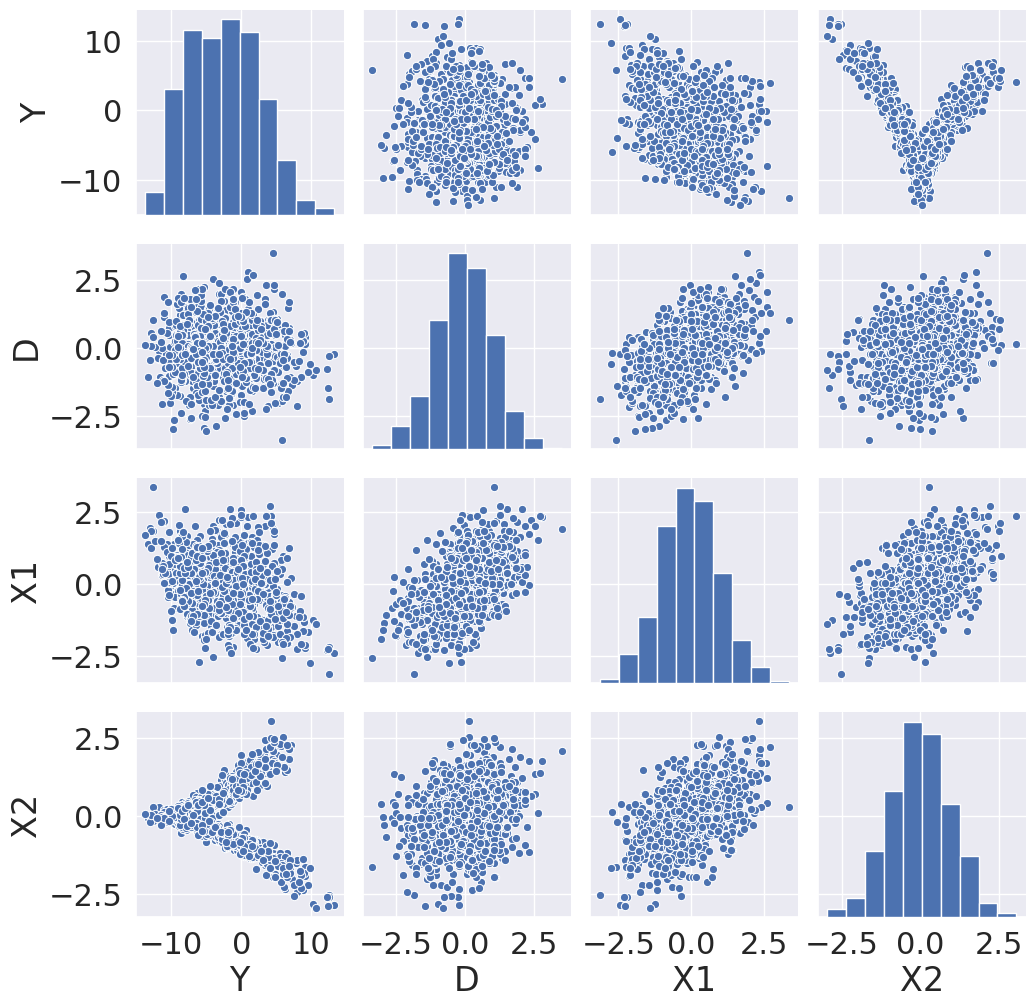

In [72]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(data=np.concatenate((Y.reshape(n,1),D,X[:,0:2]),1), 
                  columns=['Y', 'D', 'X1', 'X2'])

sns.set(font_scale=2)
sns.pairplot(df)
fig.set_size_inches(10, 10)
plt.savefig('pairs.pdf', bbox_inches="tight")

In [5]:
import statsmodels.api as sm

def naive_marginal(Y, D):
    OLS = sm.OLS(Y,sm.add_constant(D))
    res = OLS.fit()
    theta_hat = res.params[1]
    return theta_hat

naive_marginal(Y, D)

0.08675092514037572

In [6]:
import statsmodels.api as sm

def naive_linear(Y, D, X):
    OLS = sm.OLS(Y,sm.add_constant(np.concatenate((D,X),1)))
    res = OLS.fit()
    theta_hat = res.params[1]
    return theta_hat

naive_linear(Y, D, X)

1.267256238933525

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor


def double_ml(Y, D, X, random_state, K=5, bbox_index=1):
    
    W = 64
       
    if bbox_index == 1:
        bbox = MLPRegressor(hidden_layer_sizes = (W, W, W, W, W),
                            learning_rate_init = 0.01,
                            activation = "relu",
                            max_iter = 500,
                            early_stopping = False,
                            solver = "adam",
                            random_state = random_state)
    else:
        bbox = RandomForestRegressor(n_estimators=20, min_samples_split=5, random_state = random_state)
    
    # Split the data into K folds
    cv = KFold(n_splits=K, random_state=random_state, shuffle=True)
    
    def one_way(idx_1, idx_2):
        n_1 = len(idx_1)
        n_2 = len(idx_2)
        
        # Compute g_hat
        bbox.fit(X[idx_1], Y[idx_1].flatten())
        g_hat = bbox.predict(X[idx_2])

        U_hat = Y[idx_2] - g_hat
        #print(np.mean(U_hat*U_hat))

        # Compute m_hat
        bbox.fit(X[idx_1], D[idx_1].flatten())
        m_hat = bbox.predict(X[idx_2])
        m_hat = np.reshape(m_hat, (n_2,1))

        # Compute V_hat
        V_hat = (D[idx_2] - m_hat).flatten()

        #print(np.mean(V_hat*V_hat))

        # Estimate theta
        theta_hat = np.mean(V_hat * (Y[idx_2]-g_hat)) / np.mean(V_hat * D[idx_2].flatten())

        return theta_hat

    theta_hat = 0.0
    for idx_1, idx_2 in cv.split(X):
        #pdb.set_trace()
        theta_hat_fold = one_way(idx_1, idx_2)
        theta_hat += (1.0/K) * theta_hat_fold
    
    return(theta_hat)

theta_hat = double_ml(Y, D, X, random_state = 2020)
print(theta_hat)

1.1224896659831163


In [8]:
from tqdm import tqdm

def run_experiment(random_state):
    Y, D, X = generate_data(n, p)
    
    theta_hat_1 = double_ml(Y, D, X, random_state=random_state, bbox_index=1)
    theta_hat_2 = double_ml(Y, D, X, random_state=random_state, bbox_index=2)
    
    theta_hat_m = naive_marginal(Y, D)
    theta_hat_l = naive_linear(Y, D, X)
    
    return theta_hat_1, theta_hat_2, theta_hat_m, theta_hat_l
    
num_exp = 100
theta_hat = np.zeros((num_exp,4))
for i in tqdm(range(num_exp)):
    theta_hat[i] = run_experiment(i)

100%|██████████| 100/100 [21:16<00:00, 12.76s/it]


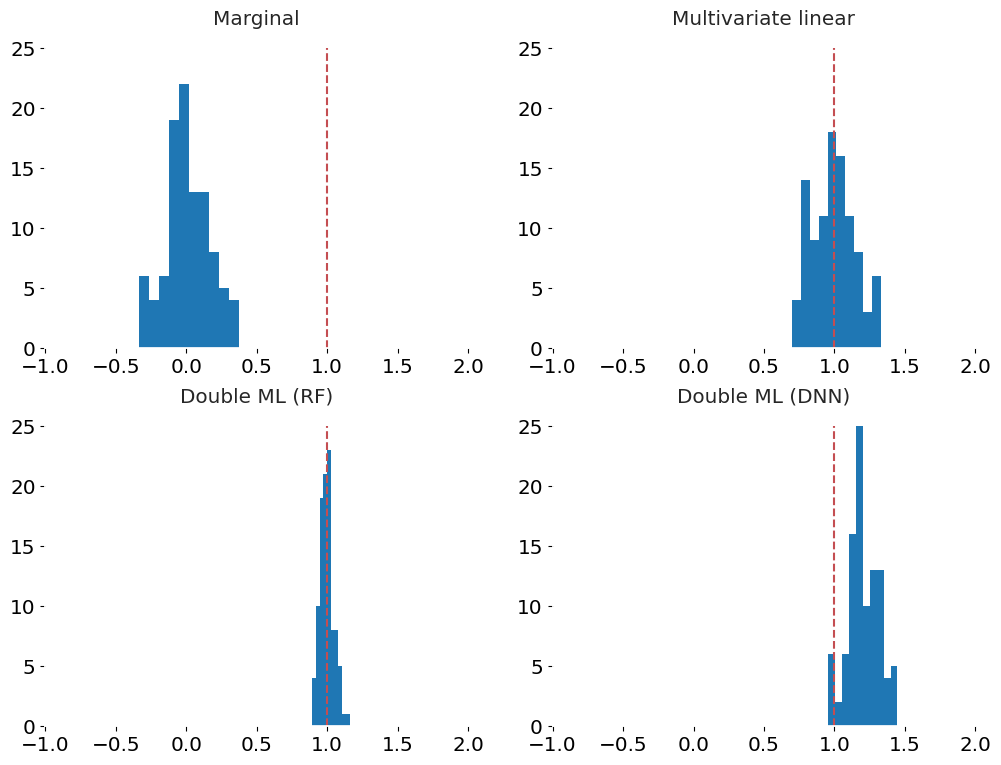

In [71]:
xmin = -1
xmax = 2

ymax = 25

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
importlib.reload(mpl); importlib.reload(plt); importlib.reload(sns)

fig, ax = plt.subplots(2, 2, figsize=(15,10))

ax[0,0].hist(theta_hat[:,2])
ax[0,0].set_xlim([xmin,xmax])
ax[0,0].vlines(theta,0,ymax,color='r', linestyles='dashed')
ax[0,0].set_title("Marginal")

ax[0,1].hist(theta_hat[:,3])
ax[0,1].set_xlim([xmin,xmax])
ax[0,1].vlines(theta,0,ymax,color='r', linestyles='dashed')
ax[0,1].set_title("Multivariate linear")

ax[1,0].hist(theta_hat[:,1])
ax[1,0].set_xlim([xmin,xmax])
ax[1,0].vlines(theta,0,ymax,color='r', linestyles='dashed')
ax[1,0].set_title("Double ML (RF)")

ax[1,1].hist(theta_hat[:,0])
ax[1,1].set_xlim([xmin,xmax])
ax[1,1].vlines(theta,0,ymax,color='r', linestyles='dashed')
ax[1,1].set_title("Double ML (DNN)")

fig.set_size_inches(12, 9)
plt.savefig('performance.pdf', bbox_inches="tight")
plt.show()